In [1]:
%pylab inline
#import matplotlib as mpl
#mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import h5py, itertools, scipy.stats
import matplotlib.pyplot as plt
import sys, os, re
from scipy.special import erf
from scipy.optimize import curve_fit
from random import gauss

In [3]:
#Here are the columns from the Hugs data 
#
#Cols. 1,2: (X,Y) stellar position in a reference system where the cluster center is in (5000,5000)
# Col.  3: F275W calibrated magnitude
# Col.  4: F275W photometric RMS
# Col.  5: F275W quality-fit parameter
# Col.  6: F275W sharp parameter 
# Col.  7: Number of F275W exposures the source is found in [99: saturated star]
# Col.  8: Number of F275W exposures the source is well measured [99: saturated star]
# Col.  9: F336W calibrated magnitude
# Col. 10: F336W photometric RMS
# Col. 11: F336W quality-fit parameter
# Col. 12: F336W sharp parameter
# Col. 13: Number of F336W exposures the source is found in [99: saturated star]
# Col. 14: Number of F336W exposures the source is well measured [99: saturated star]
# Col. 15: F438W calibrated magnitude
# Col. 16: F438W photometric RMS
# Col. 17: F438W quality-fit parameter
# Col. 18: F438W sharp parameter 
# Col. 19: Number of F438W exposures the source is found in [99: saturated star]
# Col. 20: Number of F438W exposures the source is well measured [99: saturated star]
# Col. 21: F606W calibrated magnitude
# Col. 22: F606W photometric RMS
# Col. 23: F606W quality-fit parameter
# Col. 24: F606W sharp parameter 
# Col. 25: Number of F606W exposures the source is found in [99: saturated star]
# Col. 26: Number of F606W exposures the source is well measured [99: saturated star]
# Col. 27: F814W calibrated magnitude
# Col. 28: F814W photometric RMS
# Col. 29: F814W quality-fit parameter
# Col. 30: F814W sharp parameter
# Col. 31: Number of F814W exposures the source is found in [99: saturated star]
# Col. 32: Number of F814W exposures the source is well measured [99: saturated star]
# Col. 33: Membership Probability [-1.0: not available]
# Cols. 34,35: Right ascension (J2000, epoch 2015.0) and 
#              Declination (J2000, epoch J2015.0) of the star, astrometrized using Gaia DR1 (Lindegren et al. 2016)  
# Cols. 36: Identification number of the star
# Cols. 37: Iteration the star was found 
#           1-5: found in F606W & F814W images 
#             6: found in F438W  images 
#             7: found in F336W  images 
#             8: found in F275W  images

In [4]:
#As a first test I'm just going to plot a completely different cluster to see what the pipline looks like if 
#I run it on a completely different cluster

f = np.loadtxt('./Hugs_photometry/hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0104_multi_v1_catalog-meth1.txt',
              dtype=object)

204038 29419 112865


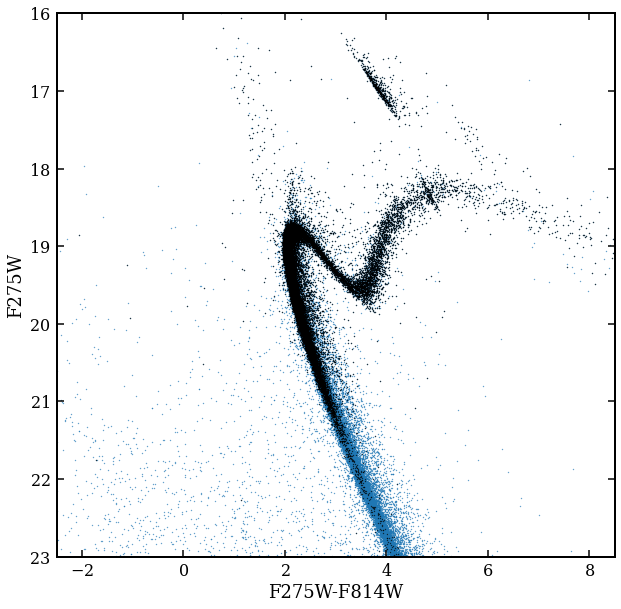

In [6]:
F275 = np.array(f[:,2],dtype=float)
F336 = np.array(f[:,8],dtype=float)
F438 = np.array(f[:,14],dtype=float)
F606 = np.array(f[:,21],dtype=float)
F814 = np.array(f[:,26],dtype=float)

F275_RMS = np.array(f[:,3],dtype=float)
F336_RMS = np.array(f[:,9],dtype=float)
F438_RMS = np.array(f[:,15],dtype=float)
F606_RMS = np.array(f[:,22],dtype=float)
F814_RMS = np.array(f[:,27],dtype=float)

#now I need to mask out the weird values (photometry set to -99.99999) and stars with
#large errors F275W > 0.03, F336W > 0.03, F438W > 0.02
obs_mask = (F275>-99.0)&(F336>-99.0)&(F438>-99.0)&(F606>-99.0)&(F814>-99.0)&(F275_RMS<0.03)&(F336_RMS<0.03)&(F438_RMS<0.02)
obs_mask_no_err = (F275>-99.0)&(F336>-99.0)&(F438>-99.0)&(F606>-99.0)&(F814>-99.0)

print(len(F275),np.sum(obs_mask),np.sum(obs_mask_no_err))

F275_orig = F275.copy()
F336_orig = F336.copy()
F438_orig = F438.copy()
F606_orig = F606.copy()
F814_orig = F814.copy()

F275 = F275[obs_mask]
F336 = F336[obs_mask]
F438 = F438[obs_mask]
F606 = F606[obs_mask]
F814 = F814[obs_mask]

fig1 = figure(1,(10,10))
plt.scatter(F275_orig-F814_orig,F275_orig,color='C0',s=0.1)
plt.scatter(F275-F814,F275,color='k',s=0.1)
plt.xlim([-2.5,8.5])
plt.ylim([23,16])
plt.xlabel('F275W-F814W')
plt.ylabel('F275W')
plt.show()

hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0288_multi_v1_catalog-meth1.txt
27221 2507 10761


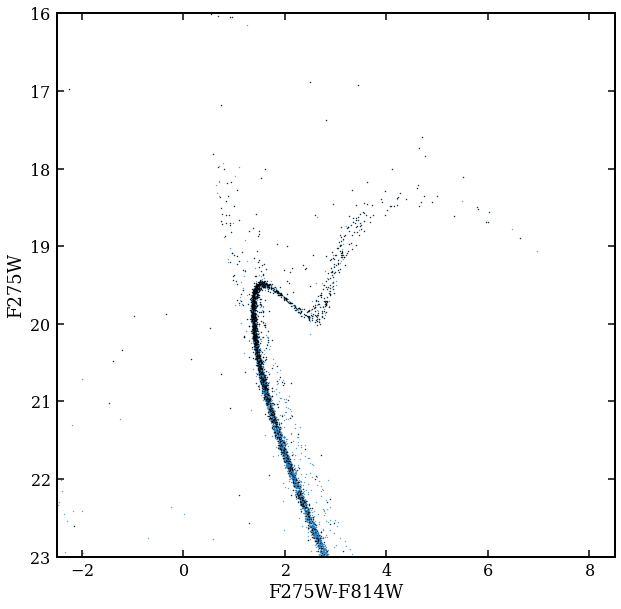

hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc1851_multi_v1_catalog-meth1.txt
166963 17537 81034


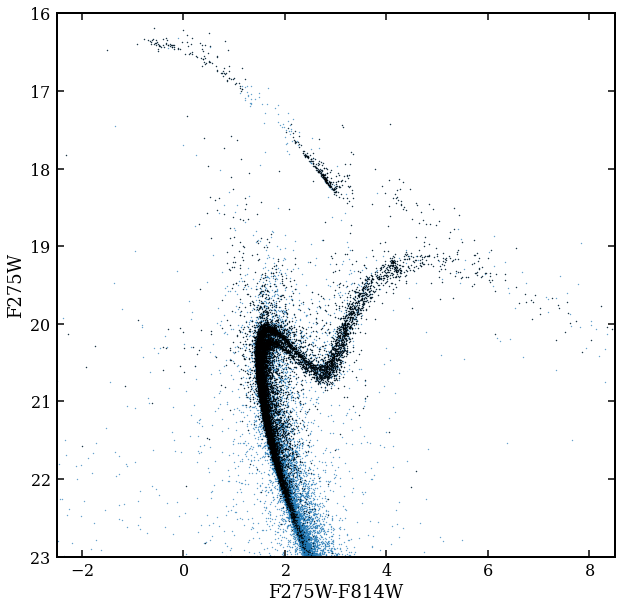

hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc2808_multi_v1_catalog-meth1.txt
343134 22604 203744


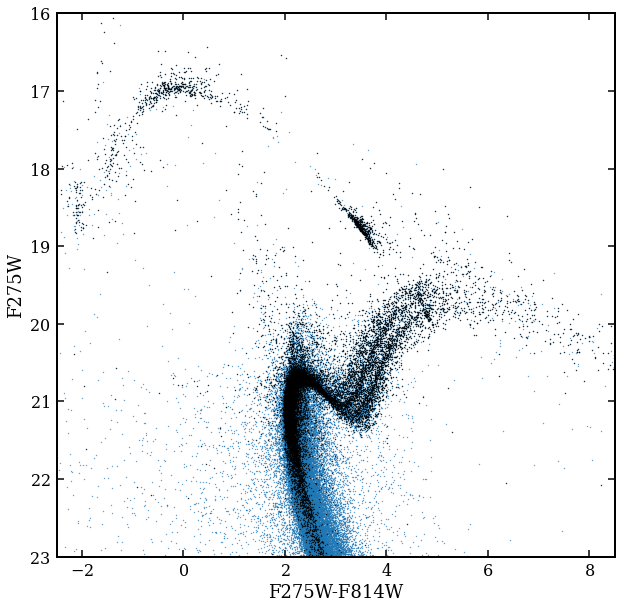

hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0104_multi_v1_catalog-meth1.txt
204038 29419 112865


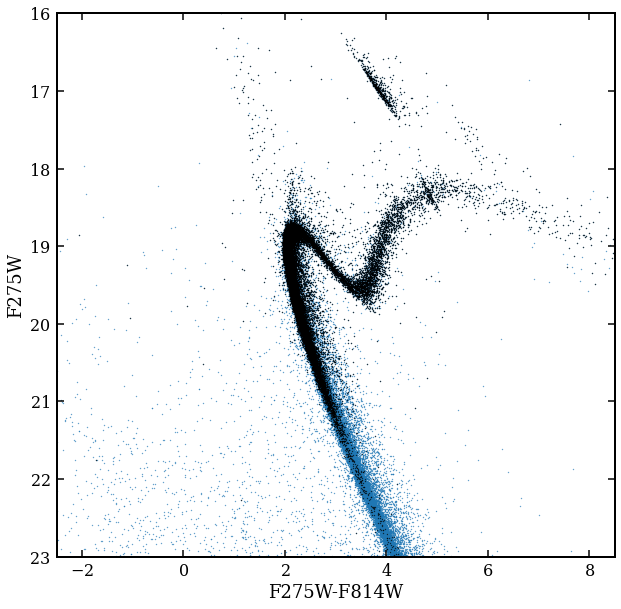

hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc1261_multi_v1_catalog-meth1.txt
115646 7039 61735


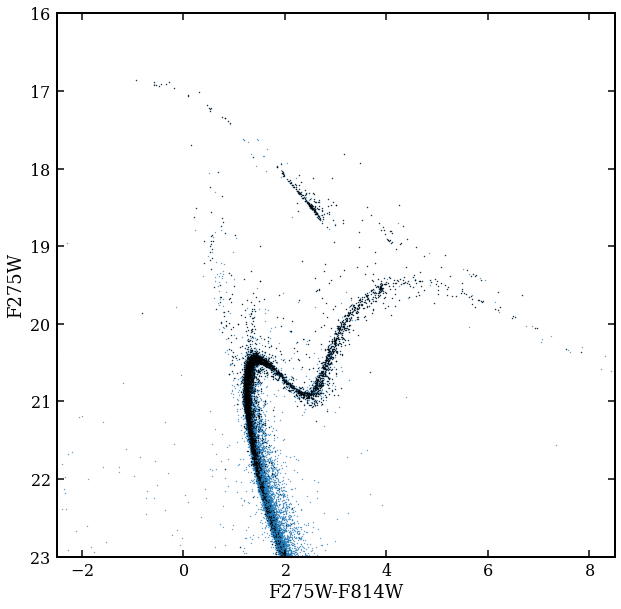

hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0362_multi_v1_catalog-meth1.txt
144320 14110 74443


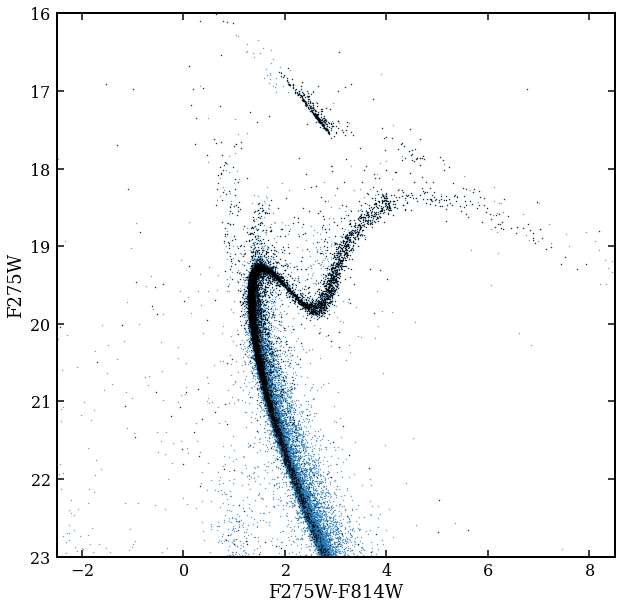

hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc2298_multi_v1_catalog-meth1.txt
22587 1775 11432


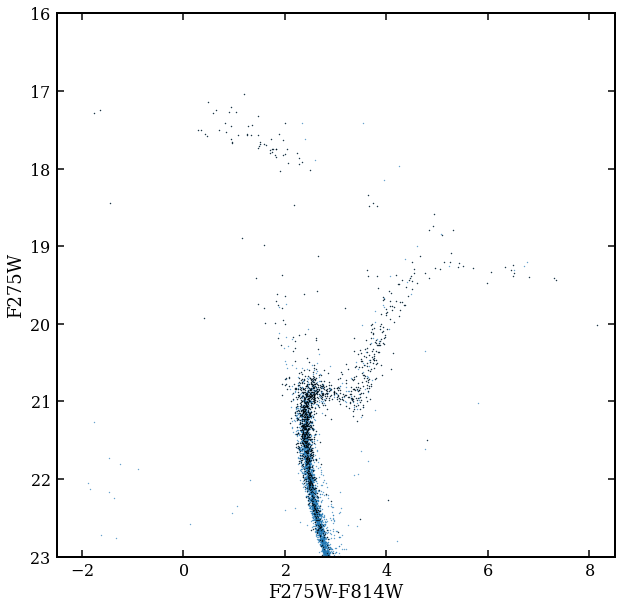

In [14]:
for cmd_file in os.listdir('./Hugs_photometry/'):
    print(cmd_file)
    f = np.loadtxt('./Hugs_photometry/'+cmd_file,
              dtype=object)
    
    F275 = np.array(f[:,2],dtype=float)
    F336 = np.array(f[:,8],dtype=float)
    F438 = np.array(f[:,14],dtype=float)
    F606 = np.array(f[:,21],dtype=float)
    F814 = np.array(f[:,26],dtype=float)

    F275_RMS = np.array(f[:,3],dtype=float)
    F336_RMS = np.array(f[:,9],dtype=float)
    F438_RMS = np.array(f[:,15],dtype=float)
    F606_RMS = np.array(f[:,22],dtype=float)
    F814_RMS = np.array(f[:,27],dtype=float)

    #now I need to mask out the weird values (photometry set to -99.99999) and stars with
    #large errors F275W > 0.03, F336W > 0.03, F438W > 0.02
    obs_mask = (F275>-99.0)&(F336>-99.0)&(F438>-99.0)&(F606>-99.0)&(F814>-99.0)&(F275_RMS<0.03)&(F336_RMS<0.03)&(F438_RMS<0.02)
    obs_mask_no_err = (F275>-99.0)&(F336>-99.0)&(F438>-99.0)&(F606>-99.0)&(F814>-99.0)

    print(len(F275),np.sum(obs_mask),np.sum(obs_mask_no_err))

    F275_orig = F275.copy()
    F336_orig = F336.copy()
    F438_orig = F438.copy()
    F606_orig = F606.copy()
    F814_orig = F814.copy()

    F275 = F275[obs_mask]
    F336 = F336[obs_mask]
    F438 = F438[obs_mask]
    F606 = F606[obs_mask]
    F814 = F814[obs_mask]

    fig1 = figure(1,(10,10))
    plt.scatter(F275_orig-F814_orig,F275_orig,color='C0',s=0.1)
    plt.scatter(F275-F814,F275,color='k',s=0.1)
    plt.xlim([-2.5,8.5])
    plt.ylim([23,16])
    plt.xlabel('F275W-F814W')
    plt.ylabel('F275W')
    plt.show()